In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
        %load_ext autoreload
%autoreload 2
from analysis_toolbox import *

In [3]:
import ast
from qualityBaseline import * 
from pycocotools.coco import COCO
import matplotlib.image as mpimg
save_db_as_csv(connect=False)
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [4]:
all_x_locs = bb_info["x_locs"]
all_y_locs = bb_info["y_locs"]

In [6]:
dataDir='../../coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=16.15s)
creating index...
index created!


In [5]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")

In [6]:
def process_raw_locs(segmentation,COCO=False):
    '''
    Given a raw string of x and y coordinates, process it
    return a list of x_locs and y_locs
    '''
    x_locs=[]
    y_locs=[]
    if COCO:
        #COCO
#         print "Process COCO"
        poly = np.array(segmentation).reshape((len(segmentation)/2, 2))
        x_locs = list(poly[:,0])
        y_locs = list(poly[:,1])
    else: 
        bbx_path,bby_path = segmentation
        x_locs = [x for x in ast.literal_eval(bbx_path) if x is not None]
        y_locs = [y for y in ast.literal_eval(bby_path) if y is not None]


    # Append the starting point again in the end to close the BB
    x_locs.append(x_locs[0])
    y_locs.append(y_locs[0])
    return x_locs,y_locs

In [7]:
bb_info['COCO Majority Vote'] = pd.Series(np.zeros(len(bb_info)), index=bb_info.index)

In [9]:
def make_iou_mask(obj_x_locs,obj_y_locs,width,height,debug=False):
    '''
    Returns a mask that has all the worker's responses overlaid on top of each other
    '''
    iou_mask = np.zeros((height,width))
    img = Image.new('L', (width, height), 0)
    for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
        ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
        mask = np.array(img)==1
        iou_mask+=mask
    if debug:
        plt.figure(figsize=(10,10))
        plt.imshow(iou_mask)
        plt.colorbar()
    return iou_mask
from PIL import Image, ImageDraw
def majority_vote(obj_x_locs,obj_y_locs,width,height): 
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    '''
    iou_mask  = make_iou_mask(obj_x_locs,obj_y_locs,width,height) 
    # Compute Jaccard Simmilarity 
    intersection = len(np.where(iou_mask == iou_mask.max())[0])
    union  =len(np.where(iou_mask !=0)[0])
    return float(union)/intersection
def area(obj_x_loc,obj_y_loc,width,height,debug = False):
    iou_mask = np.zeros((height,width))
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(zip(obj_x_loc,obj_y_loc), outline=1, fill=1)
    iou_mask = np.array(img)==1
    if debug: 
        plt.figure(figsize=(5,5))
        plt.imshow(iou_mask)
        plt.colorbar()
    area = len(np.where(iou_mask==1)[0])
    return area
def precision(obj_x_locs,obj_y_locs,width,height):
    iou_mask  = make_iou_mask(obj_x_locs,obj_y_locs,width,height,debug=True) 
    print iou_mask.max()
    intersection = len(np.where(iou_mask == iou_mask.max())[0])
    worker_bb_area  = area(obj_x_locs[0],obj_y_locs[0],width,height,debug=True)
    print "Intersection: ", intersection
    print "Worker BB area: ",worker_bb_area
    return intersection/float(worker_bb_area)
def recall(obj_x_locs,obj_y_locs,width,height):
    iou_mask  = make_iou_mask(obj_x_locs,obj_y_locs,width,height) 
    intersection = len(np.where(iou_mask == iou_mask.max())[0])
    truth_bb_area  = area(obj_x_locs[1],obj_y_locs[1],width,height,debug=True)
    print "Intersection: ", intersection
    print "Truth BB area: ",truth_bb_area
    return intersection/float(truth_bb_area)

In [16]:
obj_x_locs=[[],[]]
obj_x_locs[0]=[273, 286, 295, 292, 295, 298, 295, 284, 275, 268, 255, 245, 232, 219, 224, 212, 217, 238, 250, 264, 272, 273]
obj_x_locs[1]=[272, 276, 289, 293, 295, 289, 272]
obj_y_locs=[[],[]]
obj_y_locs[0]=[536, 534, 548, 556, 562, 571, 581, 585, 573, 582, 591, 581, 596, 589, 565, 552, 531, 525, 529, 525, 527, 536]
obj_y_locs[1]=[544, 571, 571, 562, 548, 541, 544]

In [337]:
# import qualityBaseline
# majority_vote(obj_x_locs,obj_y_locs,width,height) == qualityBaseline.majority_vote(obj_x_locs,obj_y_locs,width,height)

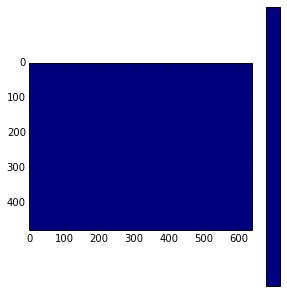

In [23]:
worker_bb_area  = area(obj_x_locs[0],obj_y_locs[0],width,height,debug=True)

0.0
Intersection:  307200
Worker BB area:  0


ZeroDivisionError: float division by zero

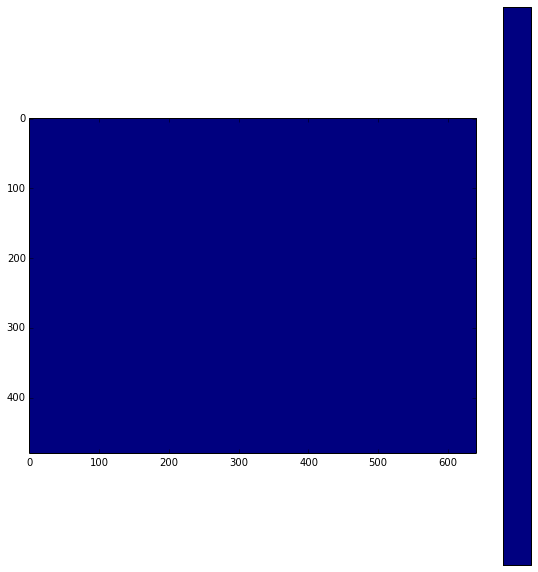

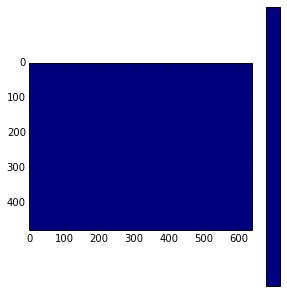

In [22]:
precision(obj_x_locs,obj_y_locs,width,height)

Intersection:  4402
Truth BB area:  584


7.537671232876712

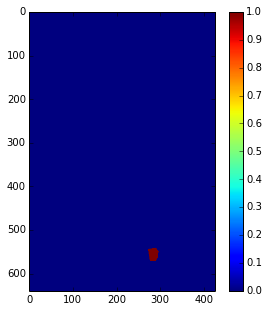

In [339]:
recall(obj_x_locs,obj_y_locs,width,height)

if total recall, that means the BB is overbounding, or maybe our ground truth is just not very good

(0, 2)

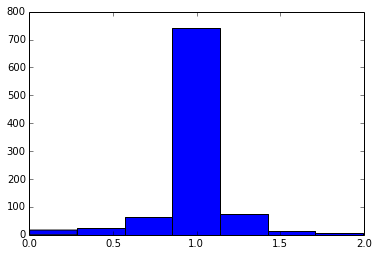

In [271]:
coco_precision = np.array(bb_info["COCO Precision"][bb_info["COCO Precision"]!=-1])
coco_recall = np.array(bb_info["COCO Recall"][bb_info["COCO Recall"]!=-1])
plt.hist(coco_precision,bins=200)
plt.xlim(0,2)

In [272]:
# plt.hist(coco_recall)
# # plt.xlim(1,1.1)

### Use Kolmogorov-Smirnov test to see how well the distributions fit a Gaussian 

In [273]:
from scipy import stats

In [274]:
stats.kstest(coco_precision, 'norm',N=10000)

(0.72091844856277332, 0.0)

(array([  1.00000000e+01,   1.03000000e+02,   6.44000000e+02,
          1.94500000e+03,   3.15600000e+03,   2.72600000e+03,
          1.13000000e+03,   2.53000000e+02,   3.10000000e+01,
          2.00000000e+00]),
 array([-3.96097842, -3.12235286, -2.28372729, -1.44510173, -0.60647616,
         0.2321494 ,  1.07077496,  1.90940053,  2.74802609,  3.58665166,
         4.42527722]),
 <a list of 10 Patch objects>)

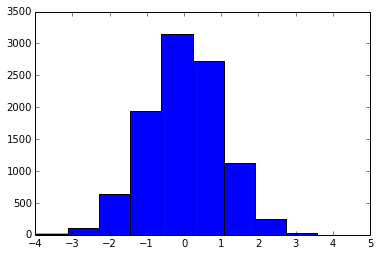

In [208]:
normcdf = stats.norm.rvs(size=10000)
plt.hist(normcdf)

In [209]:
stats.kstest(normcdf, 'norm')

(0.0070343181130699817, 0.70551484356445149)

# Finding ground truth drawn by me in sandbox (Worker ID:  ANZZ9RHXAFTSH )

In [112]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")

In [103]:
worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)

In [104]:
myID = int(worker_info[worker_info.turker=="ANZZ9RHXAFTSH"].id)

In [105]:
myBBG = bb_info[bb_info.worker_id==myID]

In [129]:
myBBG.to_csv("my_ground_truth.csv")

In [130]:
# ground_truth["My x_locs"] = myBBG["x_locs"]
# ground_truth["My y_locs"] = myBBG["y_locs"]

In [88]:
# myBBG.to_csv("my_ground_")

In [146]:
1 in np.array(object_tbl.object_id)

True

In [148]:
missed = [] 
for i in np.array(object_tbl.object_id):
    if i not in np.array(myBBG.object_id):
        missed.append(i)

In [149]:
missed

[10, 12, 14, 15]

In [82]:
np.where(bb_info[bb_info.worker_id==myID] not in o

43

In [81]:
len(object_tbl)

47

### Visualize all bounding boxes drawn by me , see which one is bad and redraw BBG 

In [151]:
my_BBG  = pd.read_csv("my_ground_truth.csv")

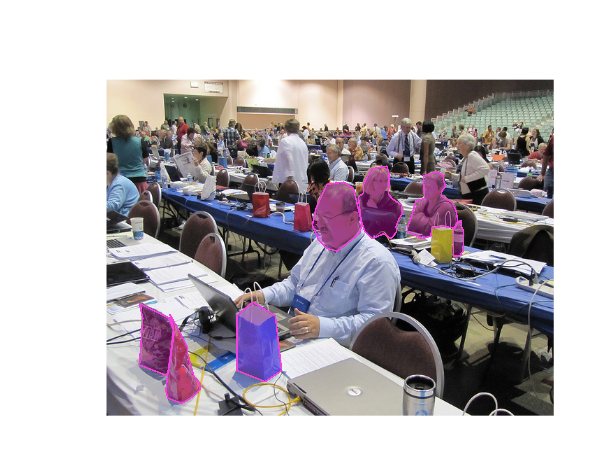

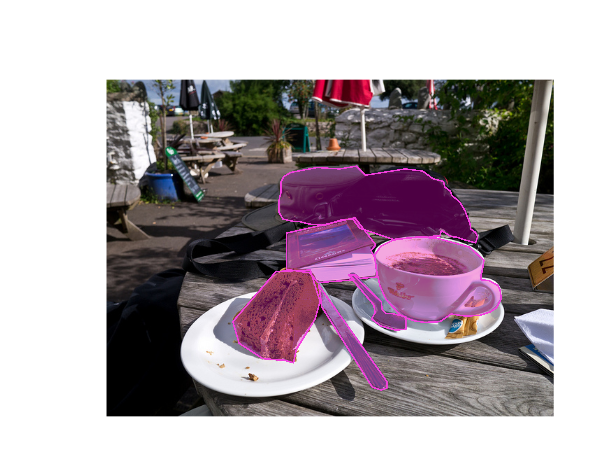

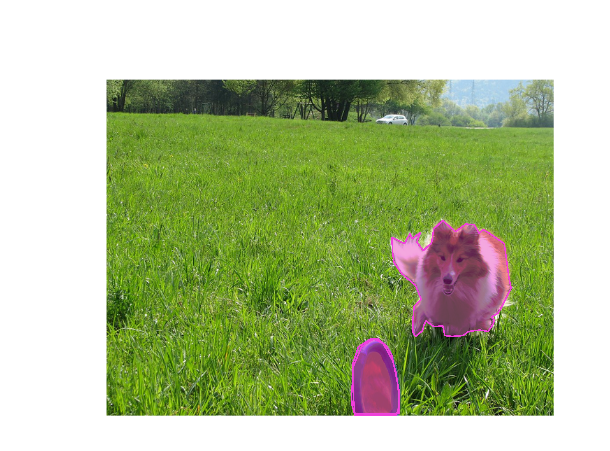

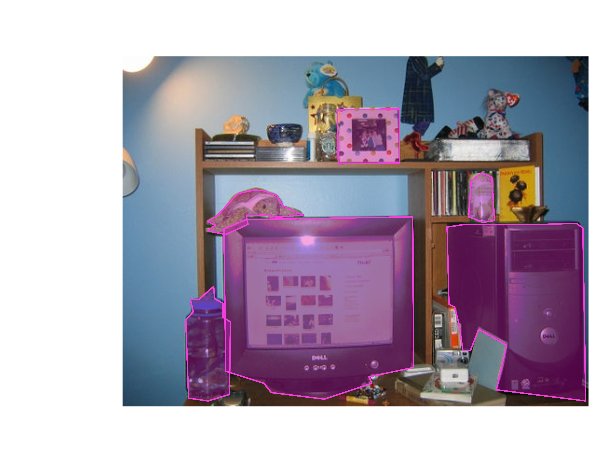

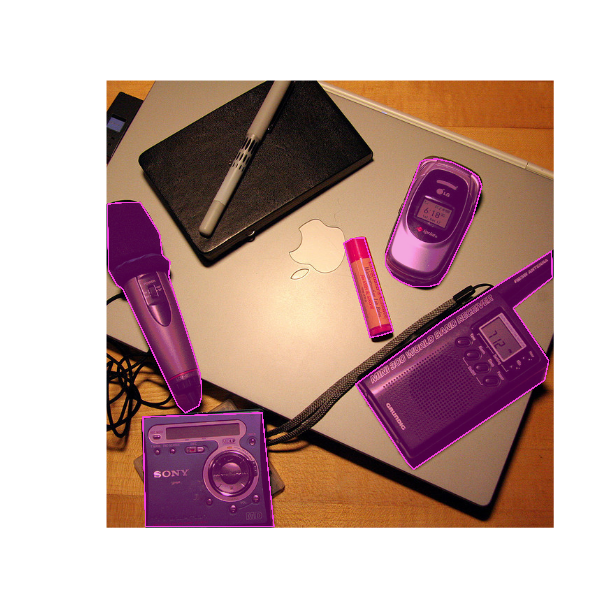

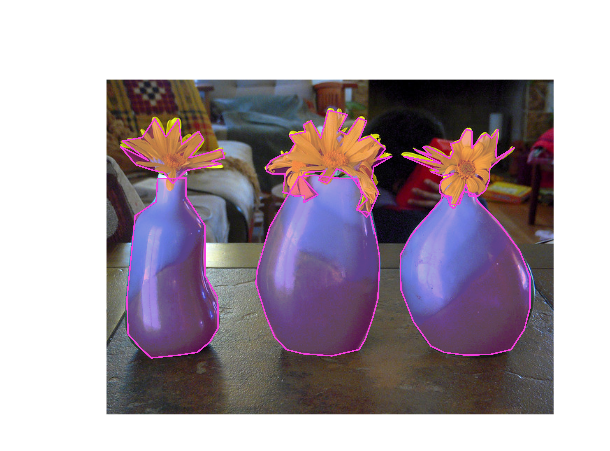

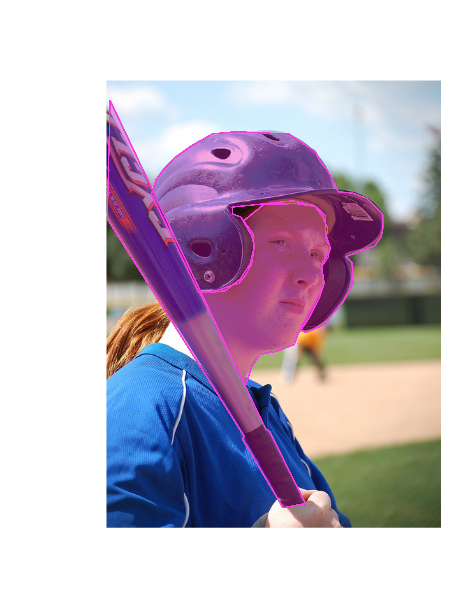

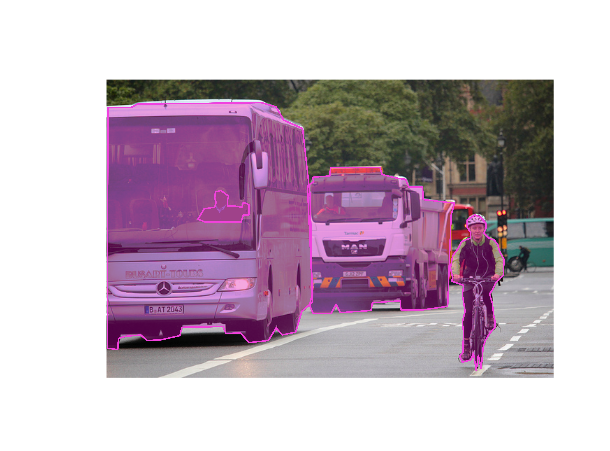

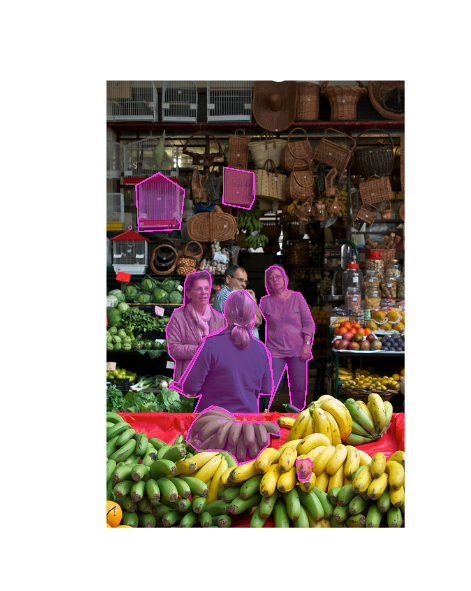

In [194]:
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        fname = "../web-app/app/static/"+img_name+".png"
        img=mpimg.imread(fname)
        width,height = get_size(fname)
        img_id = int(img_name.split('_')[-1])
        plt.figure(figsize =(10,10))
        plt.imshow(img)
        plt.axis("off")

        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]

        #for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
        for bb in bb_info.iterrows():
            oid = bb[1]["object_id"]
            bbx_path= bb[1]["x_locs"]
            bby_path= bb[1]["y_locs"]
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
#                 worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
                ground_truth_match = my_BBG[my_BBG.object_id==oid]
                x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
                plt.plot(x_locs,y_locs,'-',color='#f442df',linewidth=0.5)
                plt.fill_between(x_locs,y_locs,color='none',facecolor='#f442df', alpha=0.01)

### Computing measures against my BBG 

In [281]:
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        fname = "../web-app/app/static/"+img_name+".png"
        img=mpimg.imread(fname)
        width,height = get_size(fname)
        img_id = int(img_name.split('_')[-1])
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
        annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(annIds)
        #for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
        for bb in bb_info.iterrows():
            oid = bb[1]["object_id"]
            bbx_path= bb[1]["x_locs"]
            bby_path= bb[1]["y_locs"]
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
                ground_truth_match = ground_truth[ground_truth.id==str(oid)]
                COCO_id = int(ground_truth_match["COCO_annIds"])
                
                #COCO-Annotations
                for ann in anns:
                    if COCO_id==-1:
                        #No BB for this object collected by MSCOCO
                        pass
                    elif ann['id'] == COCO_id: 
#                         print COCO_id
                        for annBB in ann["segmentation"]:
                            coco_x_locs,coco_y_locs = process_raw_locs(annBB,COCO=True)
    #                         print ann["segmentation"]
#                             print majority_vote([worker_x_locs,bbg_x_locs],[worker_y_locs,bbg_y_locs],width,height)                
                            obj_x_locs = [worker_x_locs,coco_x_locs]
                            obj_y_locs = [worker_y_locs,coco_y_locs]
                            bb_info = bb_info.set_value(bb[0],"COCO Majority Vote",majority_vote(obj_x_locs,obj_y_locs,width,height))                
                            #bb_info = bb_info.set_value(bb[0],"Munkres Euclidean",DistAllWorkers(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Precision",precision(obj_x_locs,obj_y_locs,width,height))                
                            bb_info = bb_info.set_value(bb[0],"COCO Recall",recall(obj_x_locs,obj_y_locs,width,height))                
                my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
                my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
                obj_x_locs = [worker_x_locs,my_x_locs]
                obj_y_locs = [worker_y_locs,my_y_locs]
                bb_info = bb_info.set_value(bb[0],"My Majority Vote",majority_vote(obj_x_locs,obj_y_locs,width,height))                
                bb_info = bb_info.set_value(bb[0],"My Precision",precision(obj_x_locs,obj_y_locs,width,height))                
                bb_info = bb_info.set_value(bb[0],"My Recall",recall(obj_x_locs,obj_y_locs,width,height))       
# replace all NAN values with -1, these are entries for which we don't have COCO ground truth
bb_info = bb_info.fillna(-1)

(0, 5)

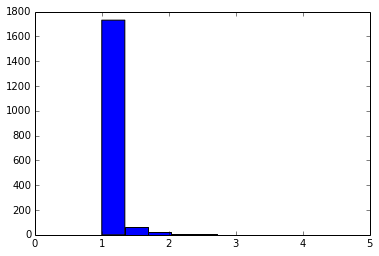

In [304]:
my_precision = np.array(bb_info["My Precision"][bb_info["My Precision"]!=-1])
my_recall = np.array(bb_info["My Recall"][bb_info["My Recall"]!=-1])
plt.figure()
plt.hist(my_precision,bins=1000)
plt.xlim(0,5)

In [285]:
stats.normaltest(my_precision)

(1253.6823651754275, 5.8389313942510351e-273)

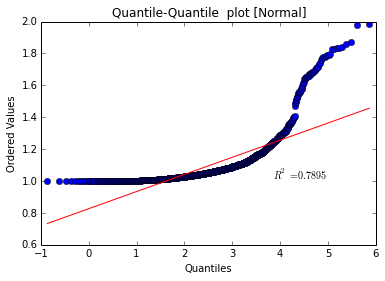

In [293]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_precision, dist=stats.norm, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Normal]")

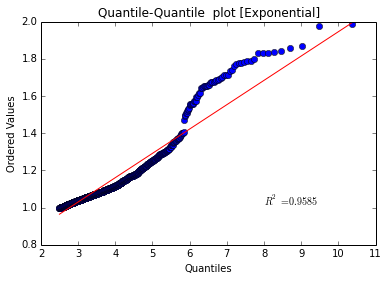

In [295]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_precision, dist=stats.expon, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Exponential]")

These distributions are very far from a normal distribution, even when you filter out the outliers 

In [292]:
stats.kstest(my_precision, 'expon',N=10000)

(0.63212055882855767, 0.0)

### Fixing the bug in the recall function : intersection should be anything above 1 in the mask 

(1, 2)

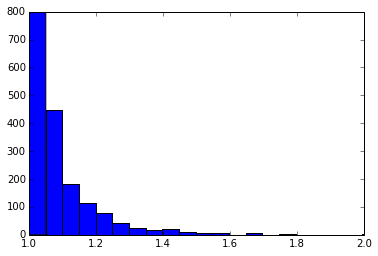

In [305]:
plt.figure()
plt.hist(my_recall,bins=1000)
plt.xlim(1,2)

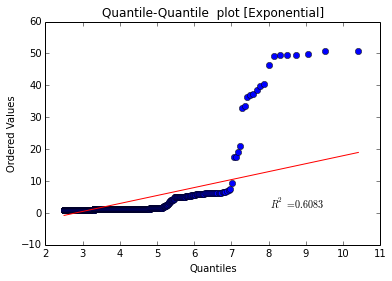

In [306]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_recall, dist=stats.expon, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Exponential]")